In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme('notebook')

## 1. Wczytanie danych

In [2]:
df = pd.read_excel("Pyły Bydgoszcz .xlsx", skiprows=5, index_col=0)

df.index.name = 'Data'
df.columns = ['PM25']

print(df.dtypes)

df.head()

PM25    float64
dtype: object


,PM25
Data,
2022-01-01,4.934921
2022-01-02,10.341562
2022-01-03,5.007348
2022-01-04,9.688094
2022-01-05,5.914476


In [3]:
def plot(df, cols, title='Wartości PM2.5'):
    fig, ax = plt.subplots(1,1,figsize=(13,5))
    for col in cols:
        sns.lineplot(x=df.index, y=df[col], ax=ax, label=col)

    ax.set(title=title)
    ax.legend()
    plt.show()

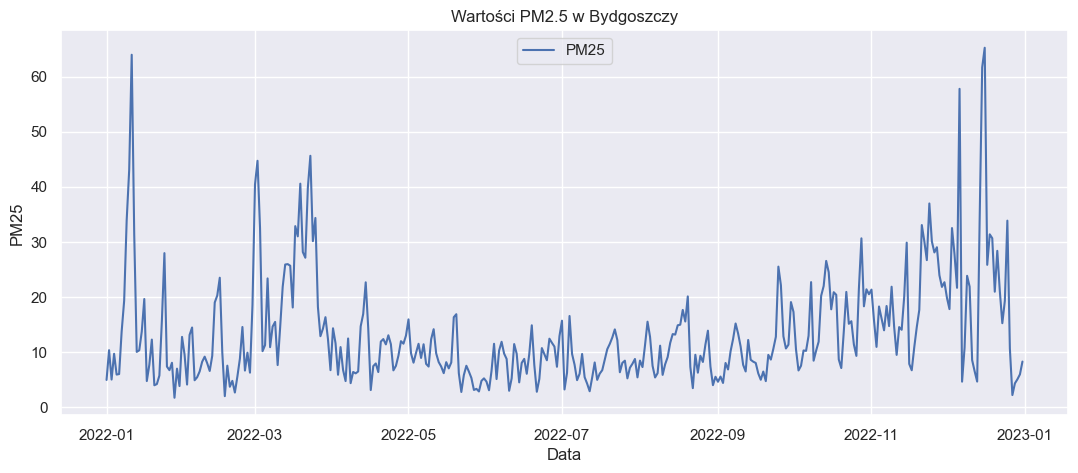

In [4]:
plot(df, ['PM25'], 'Wartości PM2.5 w Bydgoszczy')

## 2. Stworzenie cech

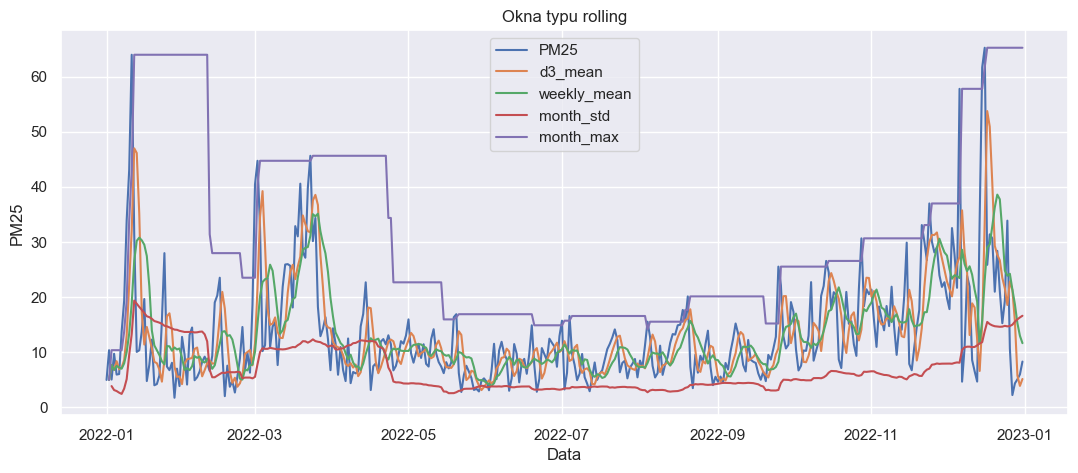

In [5]:
d3_mean = df.PM25.rolling(window='3D', closed='left').mean() # zamiast shift
weekly_mean = df.PM25.rolling(window='7D', closed='left').mean()
month_std = df.PM25.rolling(window='30D', closed='left').std()
month_max = df.PM25.rolling(window='30D', closed='left').max()

df['d3_mean'] = d3_mean
df['weekly_mean'] = weekly_mean
df['month_max'] = month_max
df['month_std'] = month_std

plot(df, ['PM25', 'd3_mean', 'weekly_mean', 'month_std', 'month_max'], title='Okna typu rolling')

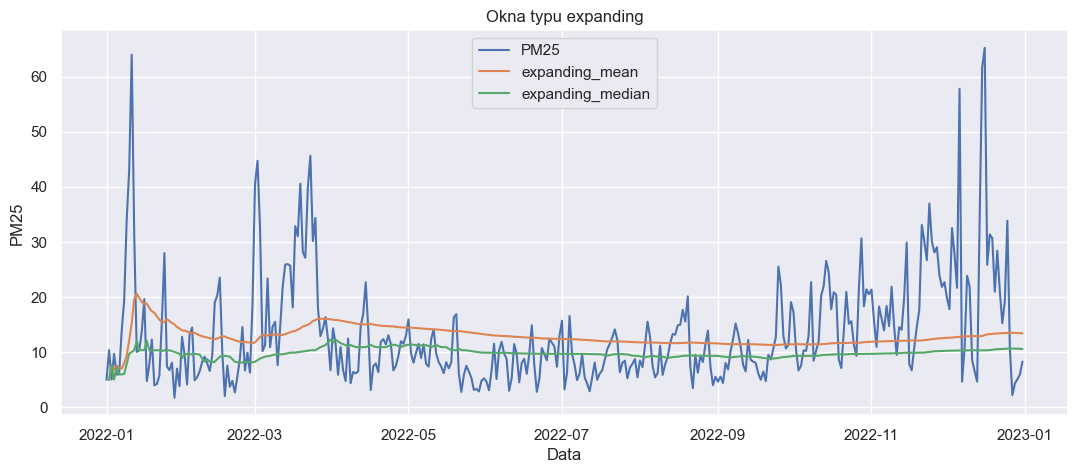

In [6]:
expanding_mean = df['PM25'].shift(1).expanding().mean()
expanding_median = df['PM25'].shift(1).expanding().median()

df['expanding_mean'] = expanding_mean
df['expanding_median'] = expanding_median

plot(df, ['PM25','expanding_mean', 'expanding_median'], 'Okna typu expanding')

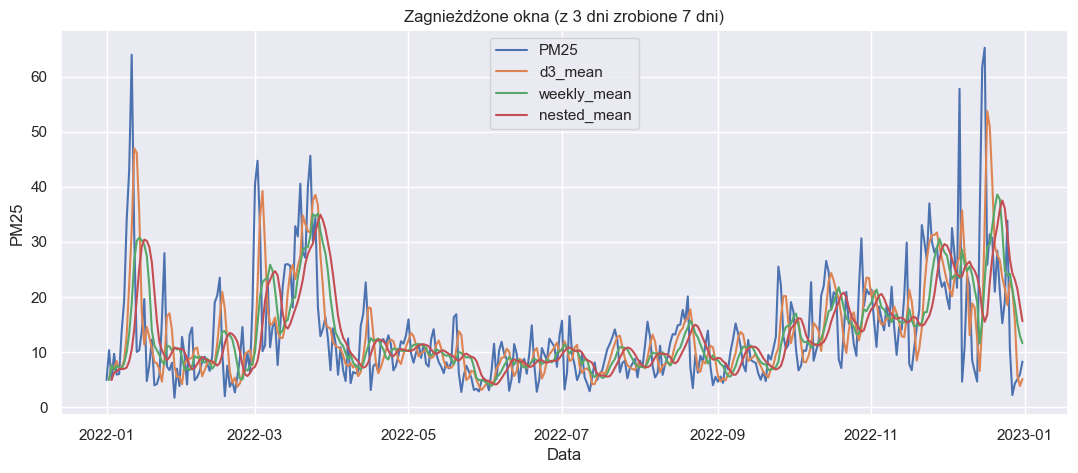

In [7]:
nested_mean = df.d3_mean.rolling('7D', closed='left').mean()

df['nested_mean'] = nested_mean

plot(df, ['PM25', 'd3_mean', 'weekly_mean', 'nested_mean'], 'Zagnieżdżone okna (z 3 dni zrobione 7 dni)')

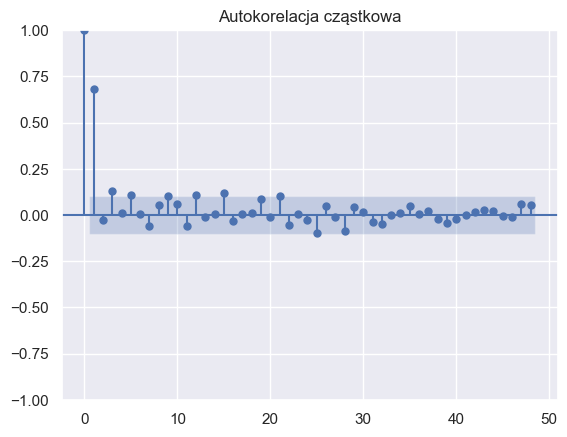

In [8]:
plot_pacf(df.PM25, title='Autokorelacja cząstkowa', lags=48)

plt.show()

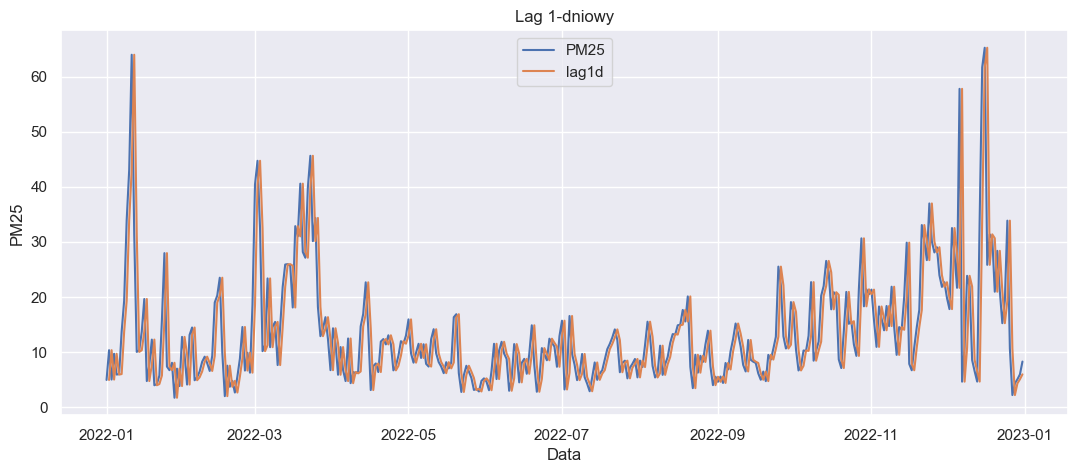

In [9]:
# Lag 1 dniowy ewentualnie mozna dodac

lag1d = df.PM25.shift(1)
df['lag1d'] = lag1d

plot(df, ['PM25', 'lag1d'], 'Lag 1-dniowy')

In [10]:
df['day_of_week'] = df.index.dayofweek
df['month_number'] = df.index.month

def get_season(month):
    if 3 <= month <= 5:
        return 1
    elif 6 <= month <= 8:
        return 2
    elif 9 <= month <= 11:
        return 3
    else:
        return 0

df['season'] = df.index.month.map(get_season)

df.head()

,PM25,d3_mean,weekly_mean,month_max,month_std,expanding_mean,expanding_median,nested_mean,lag1d,day_of_week,month_number,season
Data,,,,,,,,,,,,
2022-01-01,4.934921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0
2022-01-02,10.341562,4.934921,4.934921,4.934921,NaN,4.934921,4.934921,NaN,4.934921,6,1,0
2022-01-03,5.007348,7.638241,7.638241,10.341562,3.823073,7.638241,7.638241,4.934921,10.341562,0,1,0
2022-01-04,9.688094,6.761277,6.761277,10.341562,3.100829,6.761277,5.007348,6.286581,5.007348,1,1,0
2022-01-05,5.914476,8.345668,7.492981,10.341562,2.924322,7.492981,7.347721,6.444813,9.688094,2,1,0


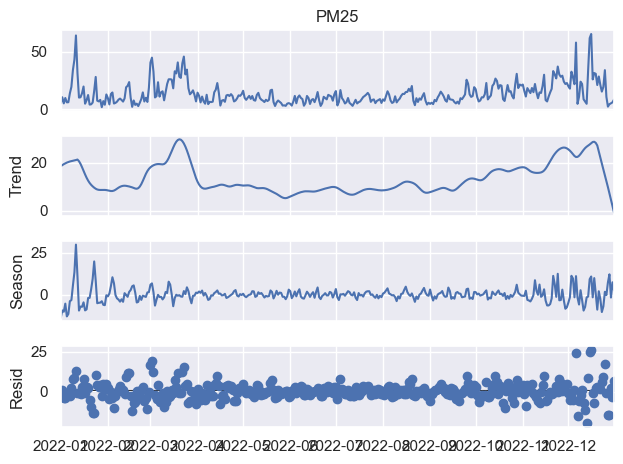

In [11]:
res = STL(df['PM25'].dropna(), period=12).fit()

df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['resid'] = res.resid

res.plot()
plt.show()

In [12]:
df.head()

,PM25,d3_mean,weekly_mean,month_max,month_std,expanding_mean,expanding_median,nested_mean,lag1d,day_of_week,month_number,season,trend,seasonal,resid
Data,,,,,,,,,,,,,,,
2022-01-01,4.934921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0,18.616101,-13.957709,0.276529
2022-01-02,10.341562,4.934921,4.934921,4.934921,NaN,4.934921,4.934921,NaN,4.934921,6,1,0,19.035325,-9.530361,0.836598
2022-01-03,5.007348,7.638241,7.638241,10.341562,3.823073,7.638241,7.638241,4.934921,10.341562,0,1,0,19.422522,-10.305573,-4.109602
2022-01-04,9.688094,6.761277,6.761277,10.341562,3.100829,6.761277,5.007348,6.286581,5.007348,1,1,0,19.770425,-5.452576,-4.629756
2022-01-05,5.914476,8.345668,7.492981,10.341562,2.924322,7.492981,7.347721,6.444813,9.688094,2,1,0,20.073551,-13.102991,-1.056085


## 3. Omówienie wyników

Wszystkie wykresy wyświetlone są w poprzedniej sekcji

1. Okna czasowe (zwykłe):
    - Średnia 3-dniowa - może być przydatna
    - Średnia tygodniowa - może być przydatna, pokazuje średnią z poprzednich 7 dni, ogólne trendy w danym tygodniu
    - Maksymalna wartość miesięczna - raczej nieprzydatna z punktu widzenia predykcji, ale dobrze pokazuje, jak kształtowały się zanieczyszczenia (w pesymistycznej wersji)
    - Miesięczne odchylenia standardowe - przydatne do stwierdzenia zmienności w danym miesiącu. Prawdopodobnie bardziej przydatne do analizy niż do modelu (gdyby model 'wiedział' co znaczą te dane to byłyby przydatniejsze), ale wciąż daje jakieś informacje
2. Okna czasowe typu expanding:
    - średnia
    - mediana
    niezbyt przydatne z punktu widzenia modelu - niewiele mówią, niewiele się różnią od zwykłej stałej
3. Zagnieżdzone okno:
    - zagnieżdżona średnia - niezbyt przydatna, niewiele wnosi, jest de facto lagiem średniej kroczącej
4. Lag:
    - na podstawie wykresu autokorelacji cząstkowej do danych dodano lag 1-dniowy, może być przydatny
5. Z daty:
    - dzień tygodnia - może być przydatny (na przestrzeni tygodnia więcej/mniej się jeździ samochodami, mocniej/słabiej się grzeje w domu itd.)
    - miesiąc - również może być przydatny
    - pora roku - prawdopodobnie najprzydatniejsza z danych 'datowych'
6. Z dekompozycji szeregu czasowego:
    - trend - zdecydowanie mógłby się przydać; trend w tym przypadku to tak naprawde sezonowe różnice
    - sezonowość - również może być przydatne
    - rezydua - niezbyt się przydadzą do ewentualnej predykcji, mogłyby doprowadzić do przeuczenia się modelu

Ogólnie zmienne które (moim zdaniem) mogą się przydać, to:
- d3_mean
- month_std
- lag1d
- day_of_week
- season
- trend
- seasonal

## 4. Zapisanie zbioru

In [13]:
df.to_csv('pm_components_all.csv')

df[['d3_mean', 'month_std', 'lag1d', 'day_of_week', 'season', 'trend', 'seasonal']].to_csv('pm_components.csv')